# Important notes
1. Replace pytorch-forecasting TFT's ```__init__.py``` file for proper wandb logging.
    Use [this](https://drive.google.com/file/d/1WKCAfUQD-R0MZBlwLl44HBvEeQw9D6_0/view?usp=sharing) to replace ```~/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py```

2. Replace pytorch-forecasting TFT's ```__init__.py``` file for Yujie's scored attention.
    Use [this](https://github.com/jjjoyce/pytorch-forecasting/blob/master/pytorch_forecasting/models/temporal_fusion_transformer/sub_modules.py) to replace ```~/python3.9/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/sub_modules.py```


TODO: Miao to add PCA and AR process in the create_dataset function

In [ ]:
%load_ext autoreload
%autoreload 2

In [7]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys

import random
import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, SMAPE, MAE, RMSE, MAPE
from pytorch_lightning.loggers import WandbLogger
import wandb

from sklearn.model_selection import train_test_split

def create_dir(dir_to_add):
    if not os.path.exists(dir_to_add):
        os.makedirs(dir_to_add)

pl.seed_everything(11785)


NUM_WORKERS = 8                                                  # Use 4 for AWS
DIR_PROJECT = '/media/user/12TB1/HanLi/GitHub/CMU11785-project/' # Change this
DIR_TRAINED = os.path.join(DIR_PROJECT, 'local_trained')         # Don't change
DIR_DATA = os.path.join(DIR_PROJECT, 'src/data')                 # Don't change
DIR_LOCAL_DATA = os.path.join(DIR_PROJECT, 'local_data')         # Don't change
DIR_BYID = os.path.join(DIR_LOCAL_DATA, 'content/databyid')      # Might need to change


DIR_TS_DATASET = os.path.join(DIR_LOCAL_DATA, 'tft_246')
first_run = False                                                # Set to False if you already created dataset

create_dir(DIR_TRAINED)
create_dir(DIR_LOCAL_DATA)

# Read subset list
ls_train_val_ids = pd.read_pickle(os.path.join(DIR_DATA, 'test_246_ids.pkl'))
ls_test_ids = random.sample(ls_train_val_ids, 200)

# Further downsample (if needed)
ls_train_val_ids = random.sample(ls_train_val_ids, 100)
ls_test_ids = random.sample(ls_train_val_ids, 50)


args = {
    # ------------------------------- Basic config ------------------------------- #
    "case": "Baseline-Han",                  # case name for logging
    'n_samples': 1000,
    'batch_size': 64,
    'n_workers' : NUM_WORKERS,
    'criterion': {
        'quantile': QuantileLoss(),
        # 'pearson': Pearson.Pearson(),   # Miao's implementation
        'other': None,                    # TODO: check out other loss (e.g., MSE)
    },
    # ----------------------------------- Data ----------------------------------- #
    "ls_train_val_ids": ls_train_val_ids,
    "ls_test_ids": ls_test_ids,
    "pre-processing": None,               # TODO: Miao to add options: ["PCA", "AR", "PCA+AR"]
    "max_prediction_length": 3,           # We may try tune this
    "max_encoder_length": 14,             # We may try tune this
    # ------------------------------ Hyperparameters -----------------------------
    'lr_s': 2e-1,                         # starting lr
    'lstm_layers': 2,
    'hidden_size': 256,
    'attention_head_size': 2,             # use multihead for large hidden size
    'dropout': 0.1,
    'hidden_continuous_size': 8,          # set to <= hidden_size
    'output_size': 7,                     # 7 quantiles for QuantileLoss by default
    'reduce_on_plateau_patience': 4,      # reduce learning rate if no improvement in validation loss after x epochs
    'gradient_clip_val': 0.1,
    # ---------------------------------- Logging --------------------------------- #
    'logging_metrics': [QuantileLoss(), SMAPE(), MAE(), RMSE(), MAPE()],
    'log_interval': 5,                    # log every n batches, set to None when try to find best lr
    'wandb_entity': '11785_project',
    'wandb_project': '11785_tft_improvement',
    'wandb_name': 'Han_test_run_111',
}


Global seed set to 11785


### Prepare dataset
* Set ```first_run = True``` to create dataset, otherwise it will read existing ones

In [8]:
# Function to create timeseries dataset
# TODO: Miao to add PCA and AR pre-processing steps
def create_dataset(
    ls_train_val_ids,
    ls_test_ids, # Should be a subset of ls_train_val_ids
    starting_time_id=400, # Use data after 400 time idx
    max_prediction_length=args['max_prediction_length'],
    max_encoder_length=args['max_encoder_length'],
    save_path=DIR_TS_DATASET,
):
    """ Train : Val : Test = 7 : 2 : 1
    """
    assert set(ls_test_ids).issubset(set(ls_train_val_ids))
    print(f"Reading raw data {len(ls_train_val_ids)} train/val samples and {len(ls_test_ids)} test samples...")
    f_cols = [f"f_{i}" for i in range(300)]
    ls_dfs = []
    for id in ls_train_val_ids:
        df_f_id = pd.DataFrame(np.load(os.path.join(DIR_BYID, f'feats/{id}.npy')), columns=f_cols)
        df_t_id = pd.DataFrame(np.load(os.path.join(DIR_BYID, f'target/{id}.npy')), columns=['target'])
        df_f_id['investment_id'] = id
        df_id = pd.concat([df_t_id, df_f_id], axis=1)
        ls_dfs.append(df_id)

    df = pd.concat(ls_dfs).reset_index().rename(columns={'index': 'time_id'})
    df = df.sort_values(by=['time_id']) # sort by time before splitting

    df = df.loc[df['time_id'] >= starting_time_id]
    df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
    df_train, df_val = train_test_split(df_train, test_size=2/9, shuffle=False)
    df_test = df_test.loc[df_test['investment_id'].isin(ls_test_ids)].reset_index(drop=True)
    df_train['investment_id'] = df_train['investment_id'].astype(str)
    df_val['investment_id'] = df_val['investment_id'].astype(str)
    df_test['investment_id'] = df_test['investment_id'].astype(str)

    print('Dataframes read complete, creating TimeSeriesDataSet...')
    
    # create the dataset from the pandas dataframe
    train_dataset = TimeSeriesDataSet(
        df_train,
        group_ids=["investment_id"],
        target="target",
        time_idx="time_id",
        min_encoder_length=max_encoder_length // 2,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["investment_id"],
        static_reals=[],
        time_varying_known_categoricals=[],
        time_varying_known_reals=f_cols,
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=['target'],
        target_normalizer=GroupNormalizer( # normalize the targe for each investment_id along corresponding time_idx
            groups=["investment_id"], 
            transformation=None # NOTE: do not use softplus or relu for encoder normalization with DeepAR
            # transformation="softplus" # NOTE: do not use softplus or relu for encoder normalization with DeepAR
        ),
        # Add additional features
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    val_dataset = TimeSeriesDataSet.from_dataset(train_dataset, df_val, predict=True, stop_randomization=True)
    test_dataset = TimeSeriesDataSet.from_dataset(train_dataset, df_test, predict=True, stop_randomization=True)

    if save_path is not None:
        print(f"Save datasets with {len(ls_train_val_ids)} train/val samples and {len(ls_test_ids)} test samples...")
        # Save dataset so we can use it next time
        create_dir(save_path)
        train_dataset.save(os.path.join(save_path, f'tft_train_{len(ls_train_val_ids)}_samples.pf'))
        val_dataset.save(os.path.join(save_path, f'tft_val_{len(ls_train_val_ids)}_samples.pf'))
        test_dataset.save(os.path.join(save_path, f'tft_test_{len(ls_test_ids)}_samples.pf'))

    return train_dataset, val_dataset, test_dataset

if first_run:
    train_dataset, val_dataset, test_dataset = create_dataset(ls_train_val_ids, ls_test_ids)
else:
    train_dataset = TimeSeriesDataSet.load(os.path.join(DIR_TS_DATASET, f'tft_train_{len(args["ls_train_val_ids"])}_samples.pf'))
    val_dataset = TimeSeriesDataSet.load(os.path.join(DIR_TS_DATASET, f'tft_val_{len(args["ls_train_val_ids"])}_samples.pf'))
    test_dataset = TimeSeriesDataSet.load(os.path.join(DIR_TS_DATASET, f'tft_test_{len(args["ls_test_ids"])}_samples.pf'))

# create dataloaders for model
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=args['batch_size'], num_workers=args['n_workers'])
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=args['batch_size'], num_workers=args['n_workers'])
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=args['batch_size'], num_workers=args['n_workers'])

### Train loop

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


new head



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 8.6 K 
3  | prescalers                         | ModuleDict                      | 4.9 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 19.2 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.7 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 M 
7  | static_context_variable_selection  | GatedResidualNetwork            | 263 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 263 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 263 

Epoch 0:   6%|▌         | 135/2218 [03:07<48:14,  1.39s/it, loss=0.155, v_num=t1q5, train_loss_step=0.160]

epoch,▁▁
lr-Ranger,▁
train_MAE_step,█▁
train_MAPE_step,█▁
train_RMSE_step,▁█
train_SMAPE_step,▁█
train_loss_step,█▁
trainer/global_step,▁▁▁▁▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄████████
epoch,0
lr-Ranger,0.2
train_MAE_step,0.49531


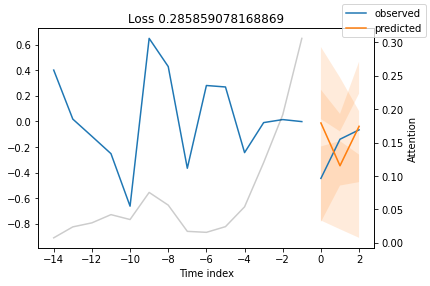

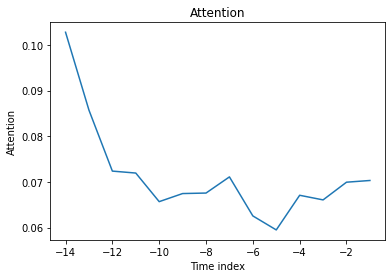

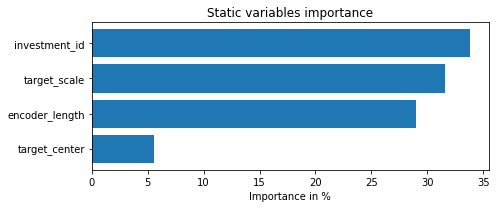

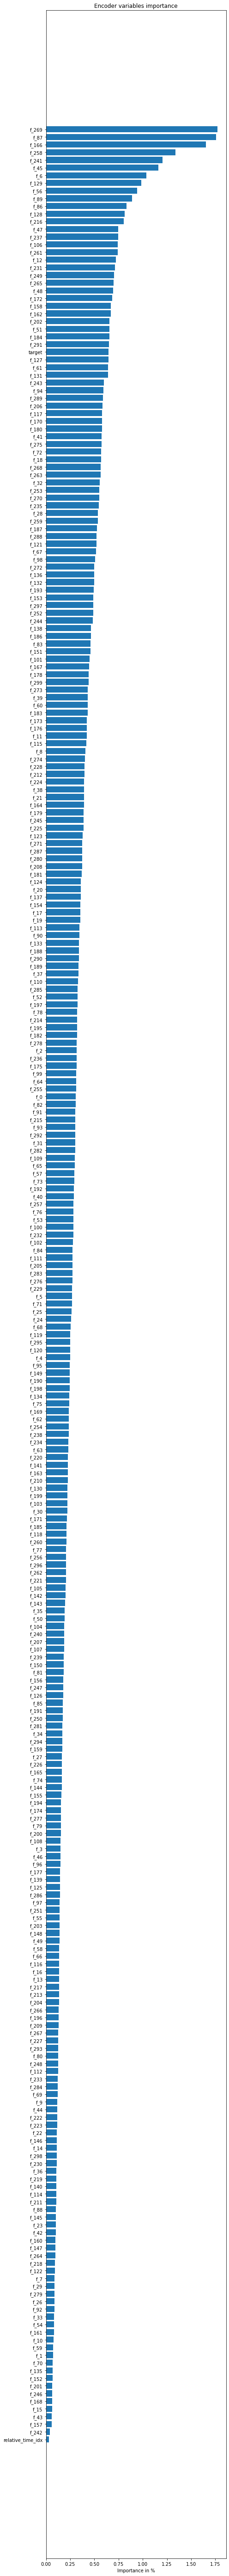

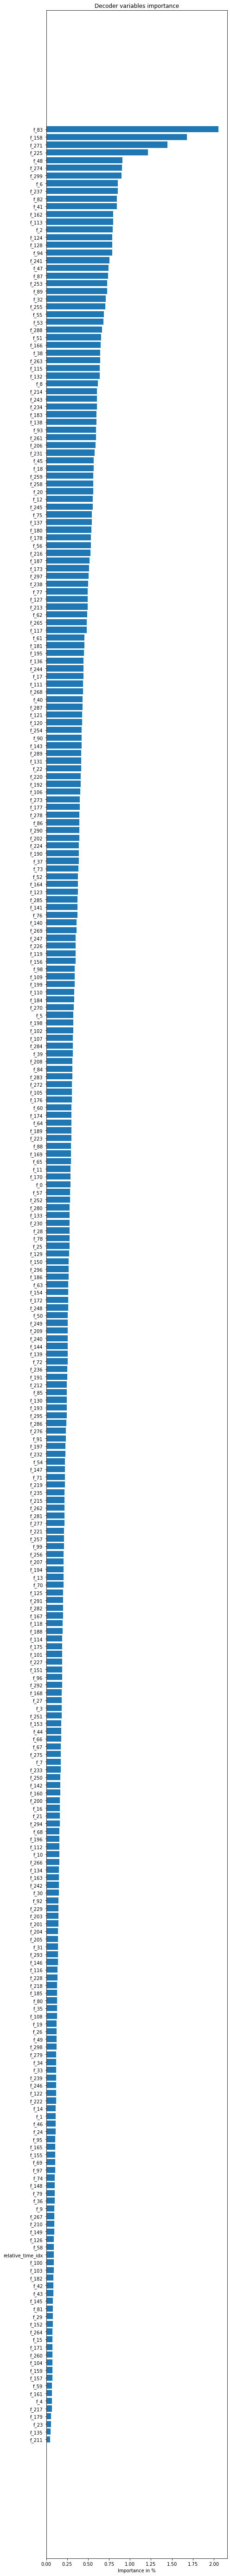

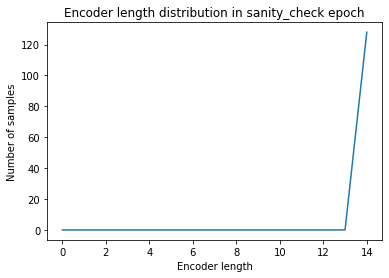

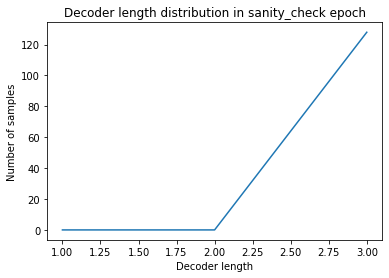

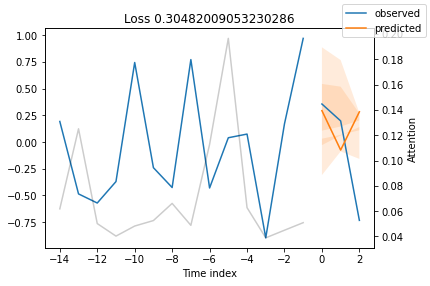

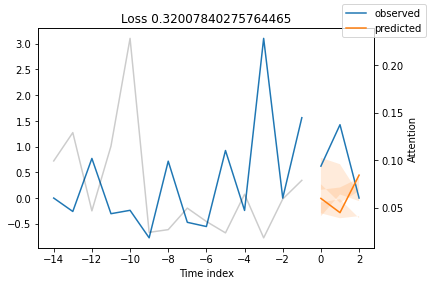

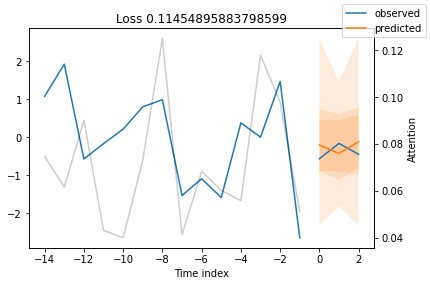

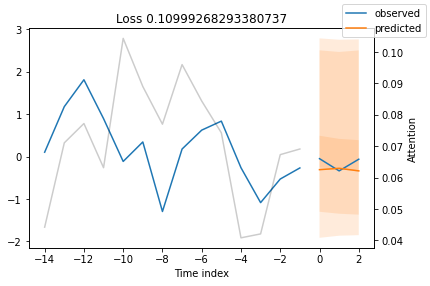

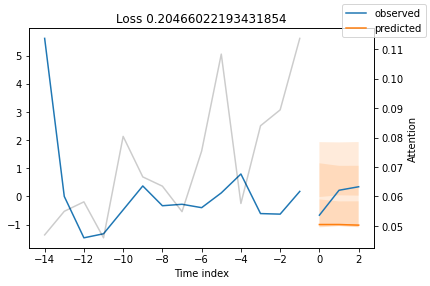

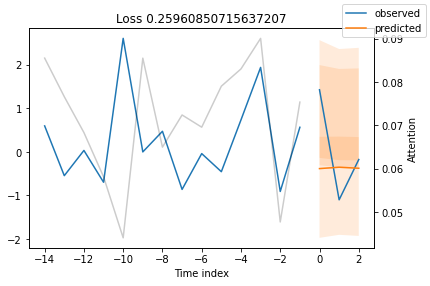

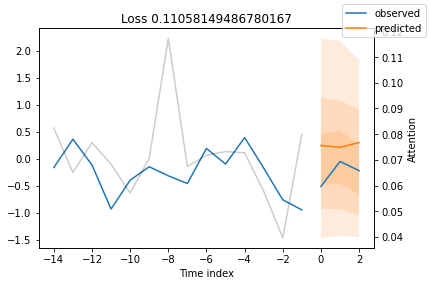

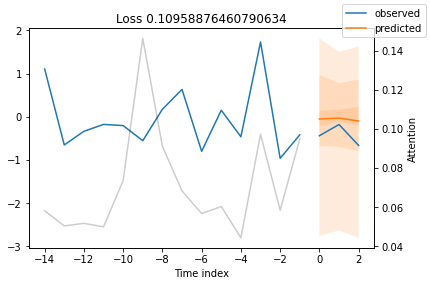

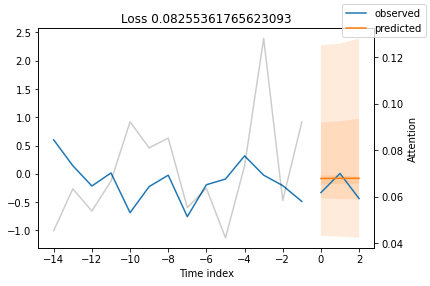

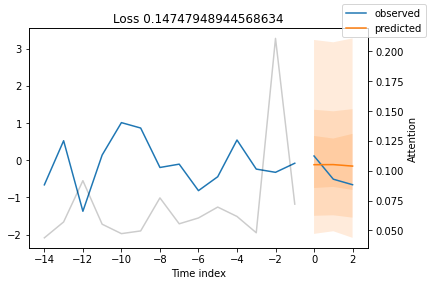

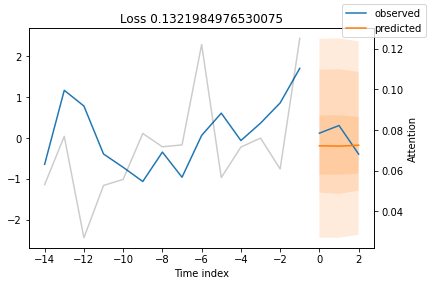

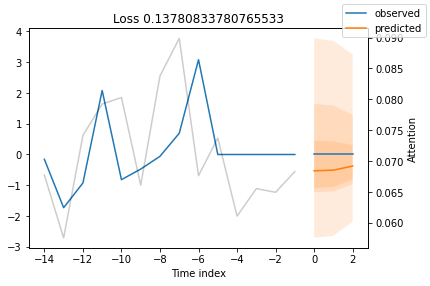

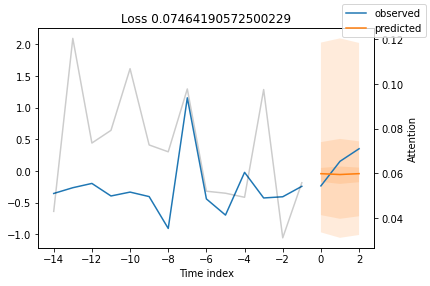

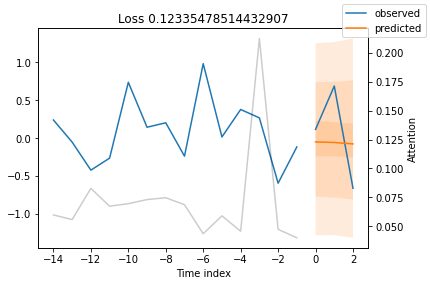

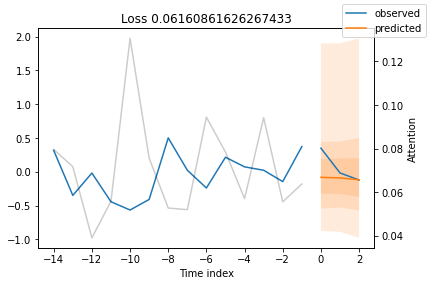

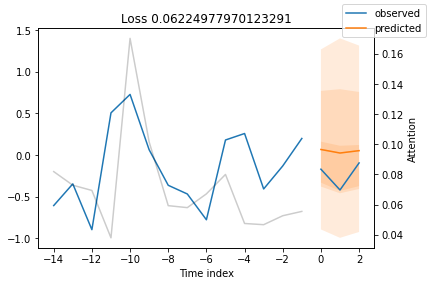

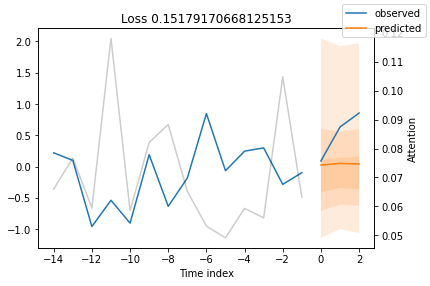

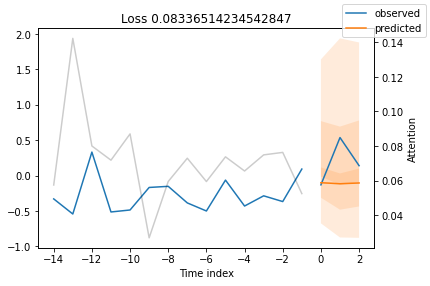

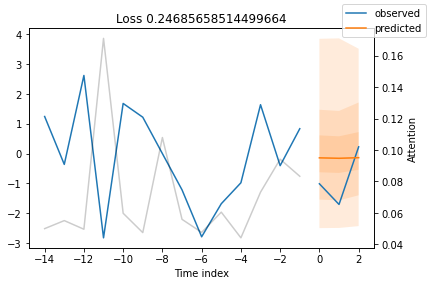

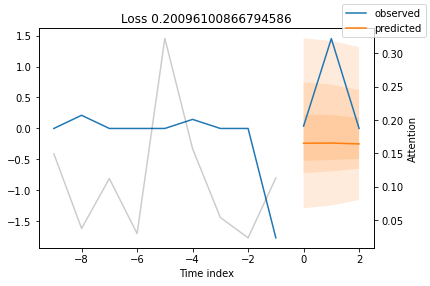

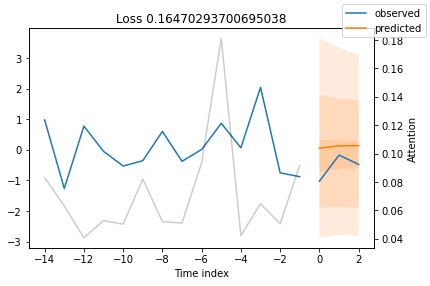

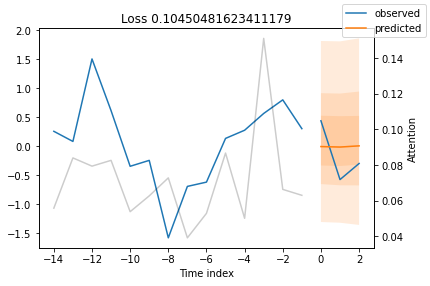

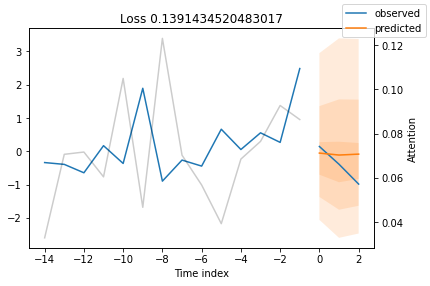

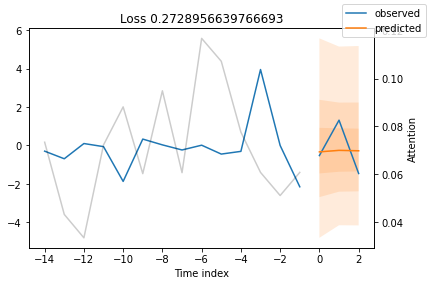

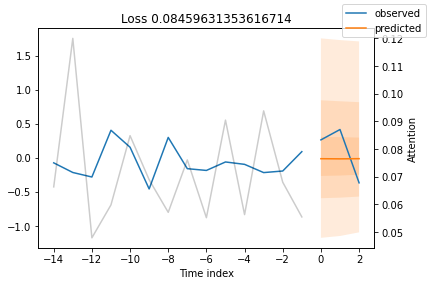

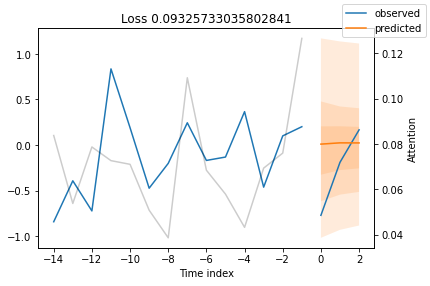

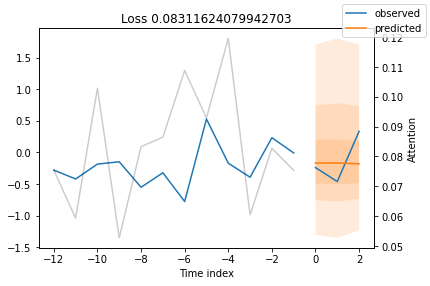

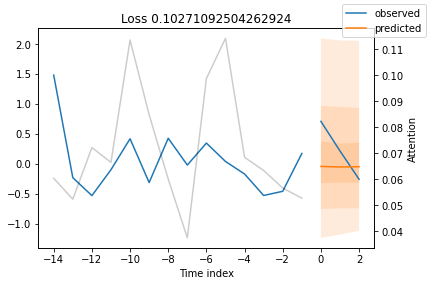

In [9]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

# For saving model
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', # val_SMAPE
    dirpath=os.path.join(DIR_TRAINED, f'{args["case"]}_ckpt'), 
    save_top_k=2, 
    filename=f'{args["case"]}_'+'{epoch:02d}-{val_loss:.2f}-{val_RMSE:.2f}'
)

logger = WandbLogger(
    log_model=True,
    entity=args['wandb_entity'],
    project=args['wandb_project'],
    name=args['wandb_name'],
    reinit=True
)

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=args['gradient_clip_val'],
    # limit_train_batches=5,  # NOTE: uncomment this line only for debugging
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    logger=logger,
)
trainer.logger.log_hyperparams(args)

tft_model = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=args["lr_s"],
    lstm_layers=args["lstm_layers"],
    hidden_size=args["hidden_size"],  # most important hyperparameter apart from learning rate
    attention_head_size=args["attention_head_size"], # number of attention heads. Set to up to 4 for large datasets
    dropout=args["dropout"],  # between 0.1 and 0.3 are good values
    hidden_continuous_size=args["hidden_continuous_size"],
    output_size=args['output_size'],
    loss=args['criterion']['quantile'],
    log_interval=args['log_interval'],  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=args['reduce_on_plateau_patience'], # reduce learning rate if no improvement in validation loss after x epochs
)

# fit network
trainer.fit(tft_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
torch.cuda.empty_cache()
# wb_run.finish()
wandb.finish()
torch.save(tft_model.state_dict(), os.path.join(DIR_TRAINED, f'tft_{args["case"]}_428.pth'))

### Test Loop

In [ ]:
# TODO: custom test loop, version by horizon length